In [1]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%pylab inline
import pandas as pd
import seaborn as sns
import geopandas as gpd
import mgwr
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from scipy.stats import skew 
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from itertools import combinations as comb

Populating the interactive namespace from numpy and matplotlib


## 1. Load Insurance Data

In [6]:
insData = pd.read_pickle('../Data/data.gz') 

In [7]:
insData.columns ## 39 columns

Index(['Nmbr', 'JobState', 'Job', 'Civil', 'YearOfBirth', 'Gender', 'Own/Rent',
       'Lang', 'Nation', 'ZIP', 'Children_0-26', 'Car1_Canton', 'Car1_Brand',
       'Car1_Class', 'Car1_Price', 'Car1_1Imtr', 'Car1_ccm', 'Car1_ClaimsCt5Y',
       'Car1_ClaimsSum5Y', 'Car2_Canton', 'Car2_Brand', 'Car2_Class',
       'Car2_Price', 'Car2_1Imtr', 'Car2_ccm', 'Car2_ClaimsCt5Y',
       'Car2_ClaimsSum5Y', 'Car_Premium', 'HH_Zip', 'HH_Ins_Sum',
       'Stand_of_furn', 'Rooms', 'Build_Zip', 'Build_Ins_Sum',
       'Year_of_constr', 'Type', 'HHaB_ClaimsCt5Y', 'HHaB_ClaimsSum5Y',
       'HH_and_Bld_Prem.'],
      dtype='object')

In [8]:
### Number of clients
ncl = len(pd.unique(insData['Nmbr']))
'The Number of Clients is %d'%ncl

'The Number of Clients is 1341328'

## 2. Load Swiss Data

In [9]:
swissData = pd.read_csv('../Data/swissData.csv') ## 90 variables + BFS Code that identifies the municipalities

In [10]:
swissData.columns

Index(['trpt1', 'trpt2', 'trpt3', 'trpt4', 'trpt5', 'trpt6', 'trpt7', 'trpt8',
       'trpt9', 'trpt10', 'trpt11', 'pop1', 'pop2', 'pop3', 'pop4', 'pop5',
       'pop6', 'pop7', 'pop8', 'pop9', 'pop10', 'pop11', 'pop12', 'pop13',
       'pop14', 'pop15', 'pop16', 'pop17', 'pop18', 'pop19', 'pop20', 'pop21',
       'pop22', 'pop23', 'pop24', 'pop25', 'pop26', 'pop27', 'pop28', 'pop29',
       'trv1', 'trv2', 'trv3', 'trv4', 'trv5', 'trv6', 'trv7', 'trv8', 'trv9',
       'trv10', 'trv11', 'esp1', 'esp2', 'esp3', 'esp4', 'esp5', 'esp6',
       'esp7', 'esp8', 'log1', 'log2', 'log3', 'log4', 'log5', 'log6', 'log7',
       'log8', 'log9', 'log10', 'log11', 'log12', 'log13', 'log14', 'log15',
       'log16', 'log17', 'log18', 'fin1', 'fin2', 'fin3', 'fin4', 'fin5',
       'fin6', 'fin7', 'fin8', 'fin9', 'egmt1', 'egmt2', 'egmt3', 'egmt4',
       'BFS'],
      dtype='object')

In [11]:
### Number of municipalities
nmun = len(swissData)
'The Number of Municipalities is %d'%nmun

'The Number of Municipalities is 170'

## 3. Merge ZIP Codes with Swiss Data

In this step we merget the Insurance Data with the Swiss Data. Swiss Data contains information of 170 municipalities and at each municiplalities a BFS code is associeted. In order to merge the two datesets we do the follwing:
1. Upload the file `zipbfs.csv` that for each ZIP CODE as a municipality BFS Number
2. Merge with swissData and get zipbfsRed
3. Merge zipbfsRed with insuranceData and get insDataRed with only the customers living the 170 municipalties 

In [12]:
zipbfs = pd.read_csv('../Data/zipbfs.csv', encoding="iso-8859-1")
zipbfs = zipbfs.drop(['Ortschaftsname', 'Zusatzziffer', 'Gemeindename', 'Kantonskí_rzel', 'E', 'N'], axis=1)
zipbfs.columns = ['ZIP', 'BFS'] ## associate the BFS to each ZIP CODE
len(zipbfs)

4147

In [13]:
### Consider only the Zip Codes that are in Swiss Data
tmp = swissData.filter(['BFS'])
zipbfsRed = pd.merge(zipbfs, tmp, on = 'BFS')
len(zipbfsRed)

534

In [14]:
len(pd.unique(zipbfsRed['BFS']))

170

In [15]:
insDataRed = pd.merge(insData, zipbfsRed, on='ZIP')
insDataRed.head()

,Nmbr,JobState,Job,Civil,YearOfBirth,Gender,Own/Rent,Lang,Nation,ZIP,...,Stand_of_furn,Rooms,Build_Zip,Build_Ins_Sum,Year_of_constr,Type,HHaB_ClaimsCt5Y,HHaB_ClaimsSum5Y,HH_and_Bld_Prem.,BFS
0,P-10000907,Angestellt,0000 ...,Ledig,1948,W,M,D,CH,5600,...,1,3.5,0,0,0,Mehrfamilienhaus über 3 Wohnungen,0,0.0,266.50,4201
1,P-10000951,Rentner,0000 ...,Verwitwet,1927,M,M,D,CH,5600,...,2,1.5,0,0,0,"Heim, Spital, Anstalt",3,3167.2,334.10,4201
2,P-10001083,Rentner,0000 ...,Verwitwet,1922,W,M,D,CH,5600,...,0,NA,0,0,0,Mehrfamilienhaus über 3 Wohnungen,1,0.0,146.15,4201
3,P-10001203,Rentner,0682 Architekt/Architektin ...,Verheiratet,1932,M,E,D,CH,5600,...,0,NA,0,0,2010,Eigentumswohnung,0,0.0,702.15,4201
4,P-10001281,Rentner,0000 ...,Verheiratet,1937,M,E,D,CH,5600,...,1,5.5,0,0,0,Einfamilienhaus,0,0.0,887.25,4201


### 3.1 Number of clients in the merged dataset

In [16]:
ncl = len(pd.unique(insDataRed['Nmbr']))
'The Number of Clients is now %d'%ncl

'The Number of Clients is now 566649'

## 4. Target Variables Selection

We select 12 Variables from the Initial Dataset

In [17]:
targetVariables = ['pop23', 'pop29', 
                   'trpt8','trpt10', 
                   'trv11', 'trv2', 
                   'esp2', 'esp3',
                   'log2', 'log3', 
                   'fin4', 'fin7']

nameVariables = ['p1','p2',
                 't1','t2',
                 'w1','w2',
                 's1','s2',
                 'h1','h2',
                 'f1','f2']

VarDescription=nameVariables

clrs = ['darkred', 'darkred',
        'darkgreen', 'darkgreen',
        'teal', 'teal',
         'y','y',
         'dimgray','dimgray',
         'sienna', 'sienna']
sd = swissData.filter(targetVariables, axis=1)
sd.columns = nameVariables

sd['t2'] = sd['t2'] / swissData['trpt9']  ## Divide by the total number of commuters
sd['w2'] = sd['w2'] / swissData['pop3']  ## Divide by the number of women
sd['s1'] = sd['s1'] / swissData['esp1']   ## Divide by the total Area
sd['s2'] = sd['s2'] / swissData['esp1']   ## Divide by the total Area
sd['f1'] = sd['f1'] / swissData['fin1']   ## Divide by the total Revenue
sd['f2'] = sd['f2'] / swissData['fin5']   ## Divide by the total Investment

## 5. Features definition from the insurance data

From the insurance data we need to aggregate information at the municipalities level, thus for each municipalities we computer median and statistical quantities of some dimensions. 

In [18]:
insDataRed.columns

Index(['Nmbr', 'JobState', 'Job', 'Civil', 'YearOfBirth', 'Gender', 'Own/Rent',
       'Lang', 'Nation', 'ZIP', 'Children_0-26', 'Car1_Canton', 'Car1_Brand',
       'Car1_Class', 'Car1_Price', 'Car1_1Imtr', 'Car1_ccm', 'Car1_ClaimsCt5Y',
       'Car1_ClaimsSum5Y', 'Car2_Canton', 'Car2_Brand', 'Car2_Class',
       'Car2_Price', 'Car2_1Imtr', 'Car2_ccm', 'Car2_ClaimsCt5Y',
       'Car2_ClaimsSum5Y', 'Car_Premium', 'HH_Zip', 'HH_Ins_Sum',
       'Stand_of_furn', 'Rooms', 'Build_Zip', 'Build_Ins_Sum',
       'Year_of_constr', 'Type', 'HHaB_ClaimsCt5Y', 'HHaB_ClaimsSum5Y',
       'HH_and_Bld_Prem.', 'BFS'],
      dtype='object')

In [19]:
### f1:   unemployment rate
### f2:   average age in the muncipality
### f3:   Fraction of owners (house)
### f4:   Fraction of foreigners
### f5:   Avg number of childer for customers with at least one children
### f6:   Market Share
### f7:   fraction of women
### f8:   average class of the cars
### f9:   average price of the cars
### f10:  95th percentile price of the cars
### f11:  Average Year of the car
### f12:  5th percentile Year of the car
### f13:  Average CCM of the car
### f14:  95th percentile CCM of the car
### f15:  Average number of claims per cars
### f16:  95th percentile number of claims of the car
### f17:  Average sum of claims of the car
### f18:  95th percentile number of price of the car
### f19:  Average sum of class premium of the car
### f20:  95th percentile  premium class of the car
### f21:  Average Class of Forniture
### f22:  95th percentile  class of fornitures
### f23:  Avg Number of Rooms 
### f24:  95th percentile  number of rooms
### f25:  Average Building Insured Sum
### f26:  95th Building Insured Sum
### f27:  Average Building Year of Constructions
### f28:  5th Percentile Building Year of Constructions
### f29:  Average type of Building
### f30:  Average number of claims per building
### f31:  Average Sum of claims per building
### f32:  95th Sum of claims per building
### f33:  Average Insured Premium
### f34:  95th Sum of Insured Premium

In [20]:
def fraction(df, col1, col2, feat,specicvalue):

    tmp = df.filter([col1,col2], axis=1)
    tmp = tmp.dropna() ## remove if we don't have info
    tmp = tmp.groupby([col2]).count()

    tmp0 = df.filter([col1,col2], axis=1)
    tmp0 = tmp0[tmp0[col1]==specicvalue]
    tmp0 = tmp0.groupby([col2]).count()
    tmp  = pd.merge(tmp,tmp0,on=col2,how='left')
    a = col1+'_x'
    b = col1+'_y'
    tmp[feat] = tmp[b]/tmp[a]
    tmp[feat] = tmp[feat].fillna(0)
    tmp = tmp.filter([feat], axis=1)
    return tmp
    

def average(df, col1, col2, feat):
    p = 0.5
    tmp = df.filter([col1, col2], axis=1)
    tmp = tmp.dropna()   ## remove nan values
    tmp = tmp[tmp[col1]>0]
    tmp = tmp.reset_index(drop=True)
    tmp = tmp.groupby(col2)[col1].quantile(p)
    tmp = pd.DataFrame(tmp)
    tmp.columns = [feat]
    return tmp

def percentile(df, col1, col2, feat, p):
    tmp = df.filter([col1, col2], axis=1)
    tmp = tmp.dropna()   ## remove nan values
    tmp = tmp[tmp[col1]>0]
    tmp = tmp.reset_index(drop=True)
    tmp = tmp.groupby(col2)[col1].quantile(p)
    tmp = pd.DataFrame(tmp)
    tmp.columns = [feat]
    return tmp

#### 5.1.1 f1: Unemployment Rate

In [21]:
col1 = 'JobState'   ## what?
col2 = 'BFS'        ## groupy municipality code
specicvalue = 'Arbeitslos   '
feat = 'f1'
tmp = fraction(insDataRed, col1, col2, feat,specicvalue)
dfFeat = tmp.filter([feat],axis=1)

#### 5.1.2 f2: Average Age

In [22]:
col1 = 'YearOfBirth'   ## what?
col2 = 'BFS'        ## groupy municipality code
tmp = insDataRed.filter([col1, col2], axis=1)
tmp = tmp.dropna() ## remove if we don't have info
tmp = tmp.groupby(by=[col2]).mean()
tmp[col1] = 2018 - tmp[col1]
tmp.columns=['f2']
dfFeat = pd.merge(dfFeat, tmp, on = col2)

#### 5.1.3 f3: Fraction of owners (house)

In [23]:
col1 = 'Own/Rent'   ## what?
col2 = 'BFS'        ## groupy municipality code
specicvalue = 'E'  
feat = 'f3'
tmp = fraction(insDataRed, col1, col2, feat,specicvalue)
tmp = tmp.filter([feat],axis=1)
dfFeat = pd.merge(dfFeat, tmp, on = col2)

#### 5.1.4 f4: Fraction of foreigners 

In [24]:
col1 = 'Nation'   ## what?
col2 = 'BFS'        ## groupy municipality code
tmp = insDataRed.filter([col1, col2], axis=1)
tmp = tmp.dropna()   ## remove nan values
tmp['swiss'] = np.where(tmp['Nation']=='CH ', 'yes', 'no') ## count if swiss or not
col1='swiss'
specicvalue = 'no'
feat = 'f4'
tmp = fraction(tmp, col1, col2, feat, specicvalue)
dfFeat = pd.merge(dfFeat, tmp, on = col2)

#### 5.1.5 f5: average number of children

In [25]:
col1 = 'Children_0-26'   ## what?
col2 = 'BFS'        ## groupy municipality code
tmp = insDataRed.filter([col1, col2], axis=1)
tmp = tmp.dropna()   ## remove nan values
tmp = tmp[tmp[col1]>0]
tmp = tmp.groupby(by=[col2]).mean()
tmp.columns=['f5']
dfFeat = pd.merge(dfFeat, tmp, on = col2)

#### 5.1.6 f6: Market Share

In [26]:
cust = insDataRed.filter(['Nmbr','BFS'], axis=1)
cust = cust.groupby(['BFS']).count()
tmp = swissData.filter(['pop1', 'BFS'], axis=1)
cust = pd.merge(cust,tmp,on='BFS')
cust['f6'] = cust['Nmbr']/cust['pop1']
cust = cust.filter(['BFS','f6'],axis=1)
dfFeat = pd.merge(dfFeat, cust, on = 'BFS')

#### 5.1.7 f7: Fraction of women

In [27]:
col1 = 'Gender'   ## what?
col2 = 'BFS'        ## groupy municipality code
tmp = insDataRed.filter([col1, col2], axis=1)
tmp = tmp.dropna()   ## remove nan values
tmp['women'] =  np.where(tmp[col1]=='W ', 'yes', 'no') ## count if swiss or not
feat = 'f7'
specicvalue = 'no'
tmp0 = tmp.groupby(['BFS']).count()

tmp = tmp[tmp[col1]=="W"]
tmp = tmp.groupby(['BFS']).count()
tmp[feat]=tmp['Gender']/tmp0['Gender']
tmp = tmp.filter([feat],axis=1)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')


#### 5.1.8 f8: Class of the car

In [28]:
col1 = 'Car1_Class'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f8'
tmp = insDataRed.filter([col1, col2], axis=1)
tmp = tmp.dropna()   ## remove nan values
tmp = tmp[tmp[col1]!= '   ']
tmp = tmp.reset_index(drop=True)
tmp[col1] = tmp[col1].astype('category')
cat_columns = tmp.select_dtypes(['category']).columns
tmp[cat_columns] = tmp[cat_columns].apply(lambda x: x.cat.codes) ## from categorical to number
tmp = tmp.groupby([col2]).mean()
tmp.columns = [feat]
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.9 f9: Price of the car

In [29]:
col1 = 'Car1_Price'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f9'
tmp = insDataRed.filter([col1, col2], axis=1)
tmp = tmp.dropna()   ## remove nan values
tmp = tmp[tmp[col1]>0]
tmp = tmp.reset_index(drop=True)
tmp = tmp.groupby([col2]).mean()
tmp.columns = [feat]
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.10 f10: 95th Percentile price of the car

In [30]:
col1 = 'Car1_Price'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f10'
tmp = insDataRed.filter([col1, col2], axis=1)
tmp = tmp.dropna()   ## remove nan values
tmp = tmp[tmp[col1]>0]
tmp = tmp.reset_index(drop=True)
tmp = tmp.groupby(col2)[col1].quantile(.95)
tmp = pd.DataFrame(tmp)
tmp.columns = [feat]
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.11 f11:  Average Year of the car

In [31]:
col1 = 'Car1_1Imtr'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f11'
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.12 f12:  5th percentile Year of the car

In [32]:
col1 = 'Car1_1Imtr'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f12'
p = 0.05
tmp = percentile(insDataRed, col1, col2, feat, p)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.13 f13:  Average CCM of the car

In [33]:
col1 = 'Car1_ccm'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f13'
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.14 f14:  95th percentile CCM of the car

In [34]:
col1 = 'Car1_ccm'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f14'
p = 0.95
tmp = percentile(insDataRed, col1, col2, feat, p)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.15 f15:  Average number of claims per cars

In [35]:
col1 = 'Car1_ClaimsCt5Y'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f15'
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.16 f16:  95th percentile number of claims of the car

In [36]:
col1 = 'Car1_ClaimsCt5Y'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f16'
p = 0.95
tmp = percentile(insDataRed, col1, col2, feat, p)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.17 f17: Average sum of claims of the car

In [37]:
col1 = 'Car1_ClaimsSum5Y'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f17'
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.18 f18:  95th percentile number of price of the car

In [38]:
col1 = 'Car1_ClaimsSum5Y'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f18'
p = 0.95
tmp = percentile(insDataRed, col1, col2, feat, p)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.17 f19: Average sum of class premium of the car

In [39]:
col1 = 'Car_Premium'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f19'
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.20 f20:  95th percentile  premium class of the car

In [40]:
col1 = 'Car_Premium'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f20'
p = 0.95
tmp = percentile(insDataRed, col1, col2, feat, p)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.21 f21:  Average Class of Forniture

In [41]:
### I will extract the same indicators for housings columns
col1 = 'Stand_of_furn'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f21'
tmp = insDataRed.filter([col1, col2], axis=1)
tmp = tmp.dropna()   ## remove nan values
tmp = tmp[tmp[col1]!= '   ']
tmp = tmp.reset_index(drop=True)
tmp[col1] = tmp[col1].astype('category')
cat_columns = tmp.select_dtypes(['category']).columns
tmp[cat_columns] = tmp[cat_columns].apply(lambda x: x.cat.codes) ## from categorical to number
tmp = tmp.groupby([col2]).mean()
tmp.columns = [feat]
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.22 f22:  95th percentile  class of fornitures

In [42]:
### I will extract the same indicators for housings columns
col1 = 'Stand_of_furn'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f22'
tmp = insDataRed.filter([col1, col2], axis=1)
tmp = tmp.dropna()   ## remove nan values
tmp = tmp[tmp[col1]!= '   ']
tmp = tmp.reset_index(drop=True)
tmp[col1] = tmp[col1].astype('category')
cat_columns = tmp.select_dtypes(['category']).columns
tmp[cat_columns] = tmp[cat_columns].apply(lambda x: x.cat.codes) ## from categorical to number
tmp = tmp.groupby(col2)[col1].quantile(0.95)
tmp = pd.DataFrame(tmp)
tmp.columns = [feat]
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.23 f23:  Average Number of Rooms

In [43]:
col1 = 'Rooms'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f23'
insDataRed[col1]=pd.to_numeric(insDataRed[col1],errors='coerce') ## transform into numeric
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.24 f24:  95th percentile  number of rooms

In [44]:
col1 = 'Rooms'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f24'
p = 0.95
tmp = percentile(insDataRed, col1, col2, feat, p)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.25 f25:  Average Building Insured Sum

In [45]:
col1 = 'Build_Ins_Sum'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f25'
insDataRed[col1]=pd.to_numeric(insDataRed[col1],errors='coerce') ## transform into numeric
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.26 f26:  95th Building Insured Sum

In [46]:
col1 = 'Build_Ins_Sum'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f26'
p = 0.95
tmp = percentile(insDataRed, col1, col2, feat, p)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.27 f27:  Average Building Year of Constructions

In [47]:
col1 = 'Year_of_constr'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f27'
#insDataRed[col1]=pd.to_numeric(insDataRed[col1],errors='coerce') ## transform into numeric
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.28 f28:  5th Percentile Building Year of Constructions

In [48]:
col1 = 'Year_of_constr'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f28'
p = 0.05
tmp = percentile(insDataRed, col1, col2, feat, p)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.29 f29:  Average type of Building

In [49]:
### I will extract the same indicators for housings columns
col1 = 'Type'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f29'
tmp = insDataRed.filter([col1, col2], axis=1)
tmp = tmp.dropna()   ## remove nan values
tmp = tmp[tmp[col1]!= '   ']
tmp = tmp.reset_index(drop=True)
tmp[col1] = tmp[col1].astype('category')
cat_columns = tmp.select_dtypes(['category']).columns
tmp[cat_columns] = tmp[cat_columns].apply(lambda x: x.cat.codes) ## from categorical to number
tmp = tmp.groupby([col2]).mean()
tmp.columns = [feat]
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.30 f30:  Average number of claims per building

In [50]:
col1 = 'HHaB_ClaimsCt5Y'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f30'
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.31 f31:  Average Sum of claims per building

In [51]:
col1 = 'HHaB_ClaimsSum5Y'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f31'
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.32 f32:  95th Sum of claims per building

In [52]:
col1 = 'HHaB_ClaimsSum5Y'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f32'
p = 0.95
tmp = percentile(insDataRed, col1, col2, feat, p)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.33 f33:  Average Insured Premium

In [53]:
col1 = 'HH_and_Bld_Prem.'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f33'
tmp = average(insDataRed, col1, col2, feat)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

#### 5.1.34 f34:  95th Sum of Insured Premium

In [54]:
col1 = 'HH_and_Bld_Prem.'   ## what?
col2 = 'BFS'        ## groupy municipality code
feat = 'f34'
p = 0.95
tmp = percentile(insDataRed, col1, col2, feat, p)
dfFeat = pd.merge(dfFeat, tmp, on = 'BFS')

In [55]:
dfFeat.to_csv('../Data/featuresListNew.csv', index=None)

In [56]:
dfFeat = pd.read_csv('../Data/featuresListMedian.csv')

## 6. Load ShapeFiles and make some Plots

In [401]:
swissData= pd.read_csv('../data/swissData.csv', encoding="iso-8859-1")
coord=pd.read_csv('../data/bfs_name_coordinates.csv',delimiter=',', encoding="iso-8859-1")
mun = gpd.read_file('../data/shapeFiles/municipalities.shp')
mun=mun.to_crs({'init': 'epsg:2056'})
mun = pd.merge(mun,coord,left_on='BFS_NUMMER',right_on='BFS')
mun = mun.drop_duplicates(subset='BFS_NUMMER', keep="last").reset_index(drop=True)
cantons = gpd.read_file("../data/shapeFiles/cantons.shp")
cantons=cantons.to_crs({'init': 'epsg:2056'})

In [402]:
mun = pd.merge(mun, swissData, on='BFS')
mun['NAME'][6]='Zurich'
mun['NAME'][62]='Geneva'

In [403]:
X=[]
Y=[]
for i in mun['geometry']:
    tmp = list(i.centroid.coords)
    X.append(tmp[0][0])
    Y.append(tmp[0][1])

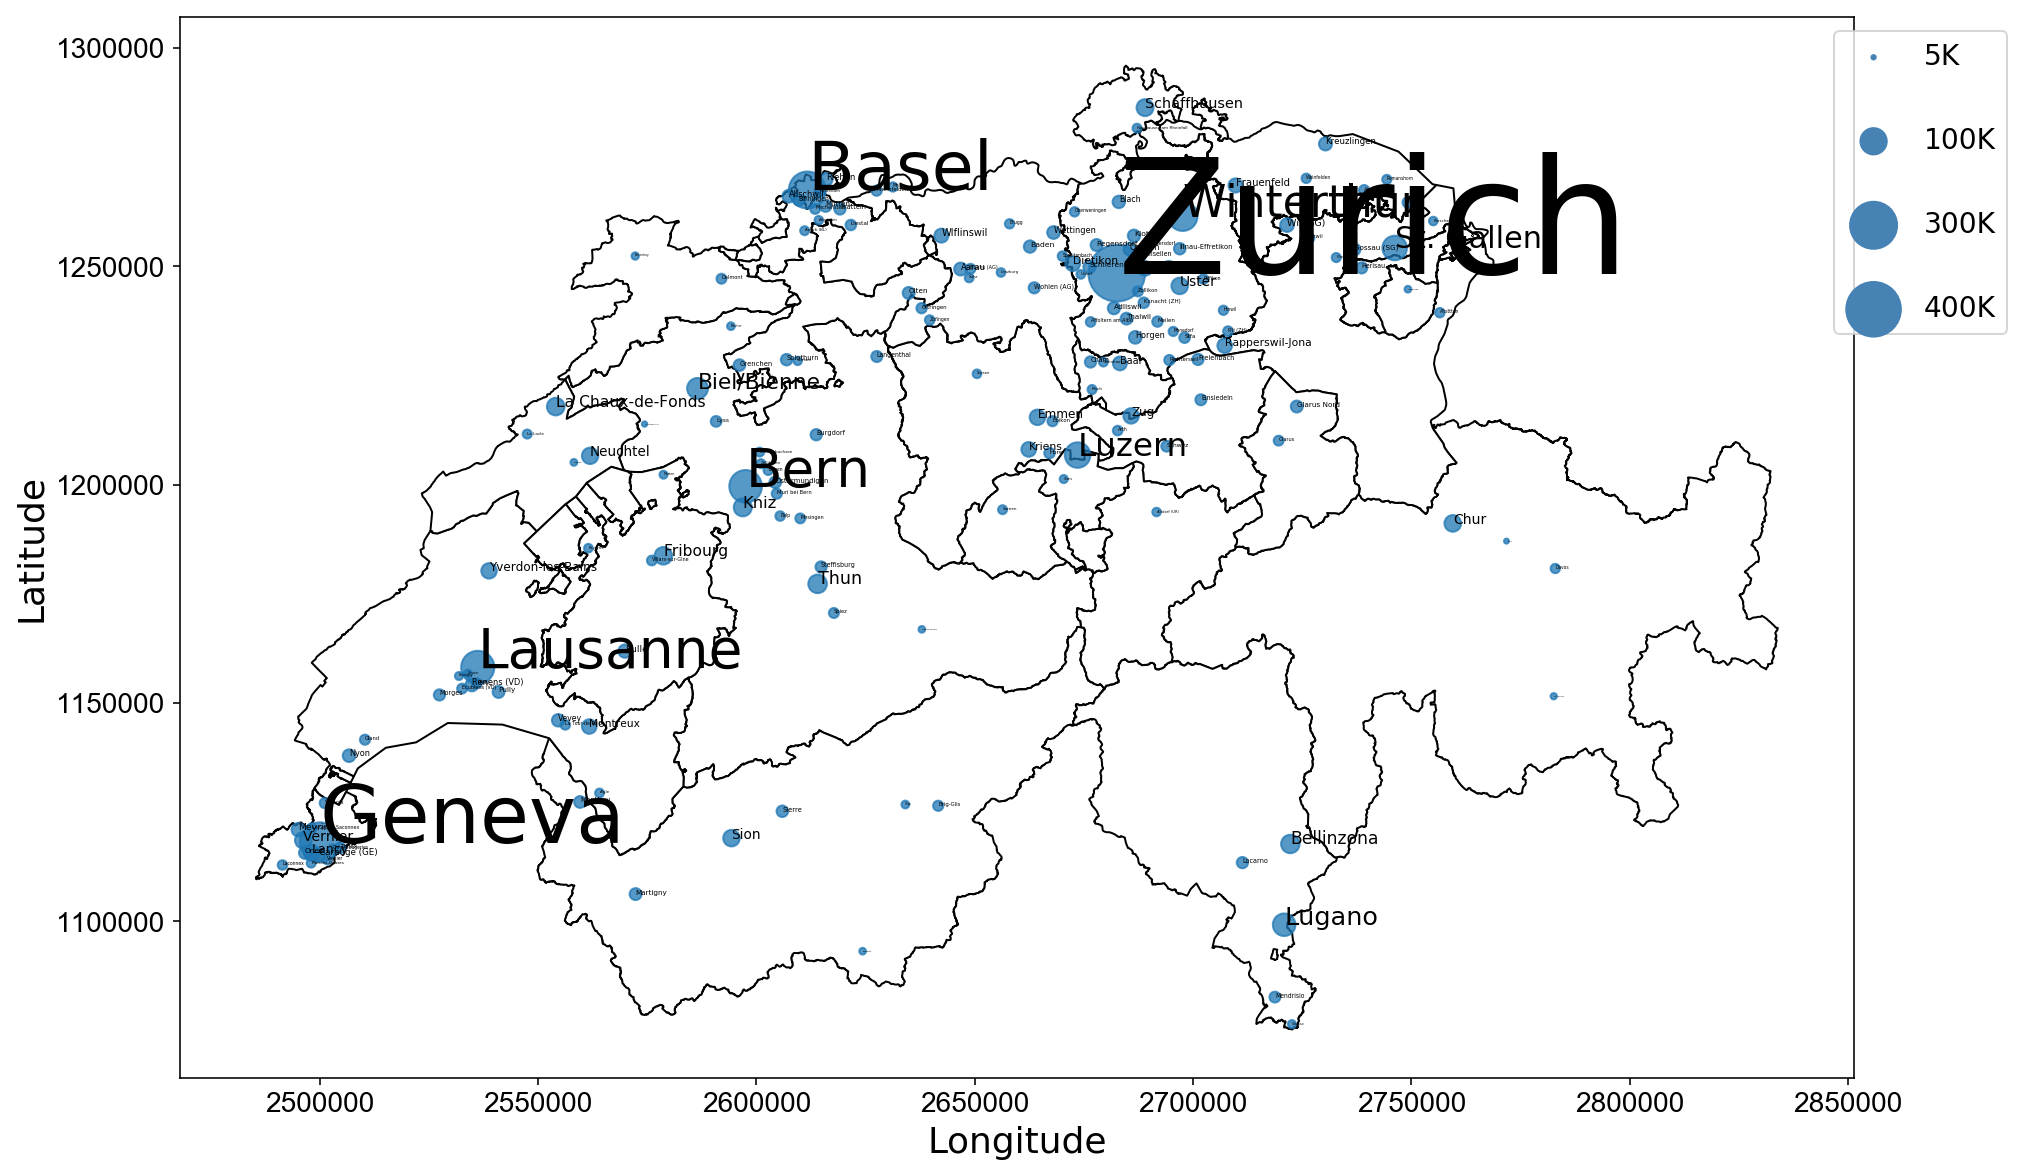

In [404]:
s = [n/500 for n in mun['pop1']]

bg_color = 'white'
fg_color = 'white'

fig, ax = plt.subplots(figsize=(15, 15), facecolor=bg_color, edgecolor=fg_color)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(14)
#ax.set_aspect('equal')
base = cantons.plot(ax = ax, color='white', edgecolor='black')
ax.scatter(X, Y, marker='o', s=s, alpha = 0.75)
#mun.plot(ax = ax, column='pop1', markersize=30,  categorical=True)
#ax.axis('off');
for i, txt in enumerate(mun['NAME']):
    ax.annotate(txt, (X[i], Y[i]), size=s[i]/10)

ax.set_ylabel('Latitude',size = 18)
ax.set_xlabel('Longitude',size= 18)
l1 = plt.scatter([],[], s=10, edgecolors='none', color='steelblue')
l2 = plt.scatter([],[], s=200, edgecolors='none', color='steelblue')
l3 = plt.scatter([],[], s=600, edgecolors='none', color='steelblue')
l4 = plt.scatter([],[], s=800, edgecolors='none', color='steelblue')
labels = ["5K", "100K", "300K", "400K"]

leg = plt.legend([l1, l2, l3, l4], labels,  bbox_to_anchor=(1.1, 1),
                 fontsize=14, 
                 scatterpoints = 1, labelspacing=2)

## 7. Features Selection

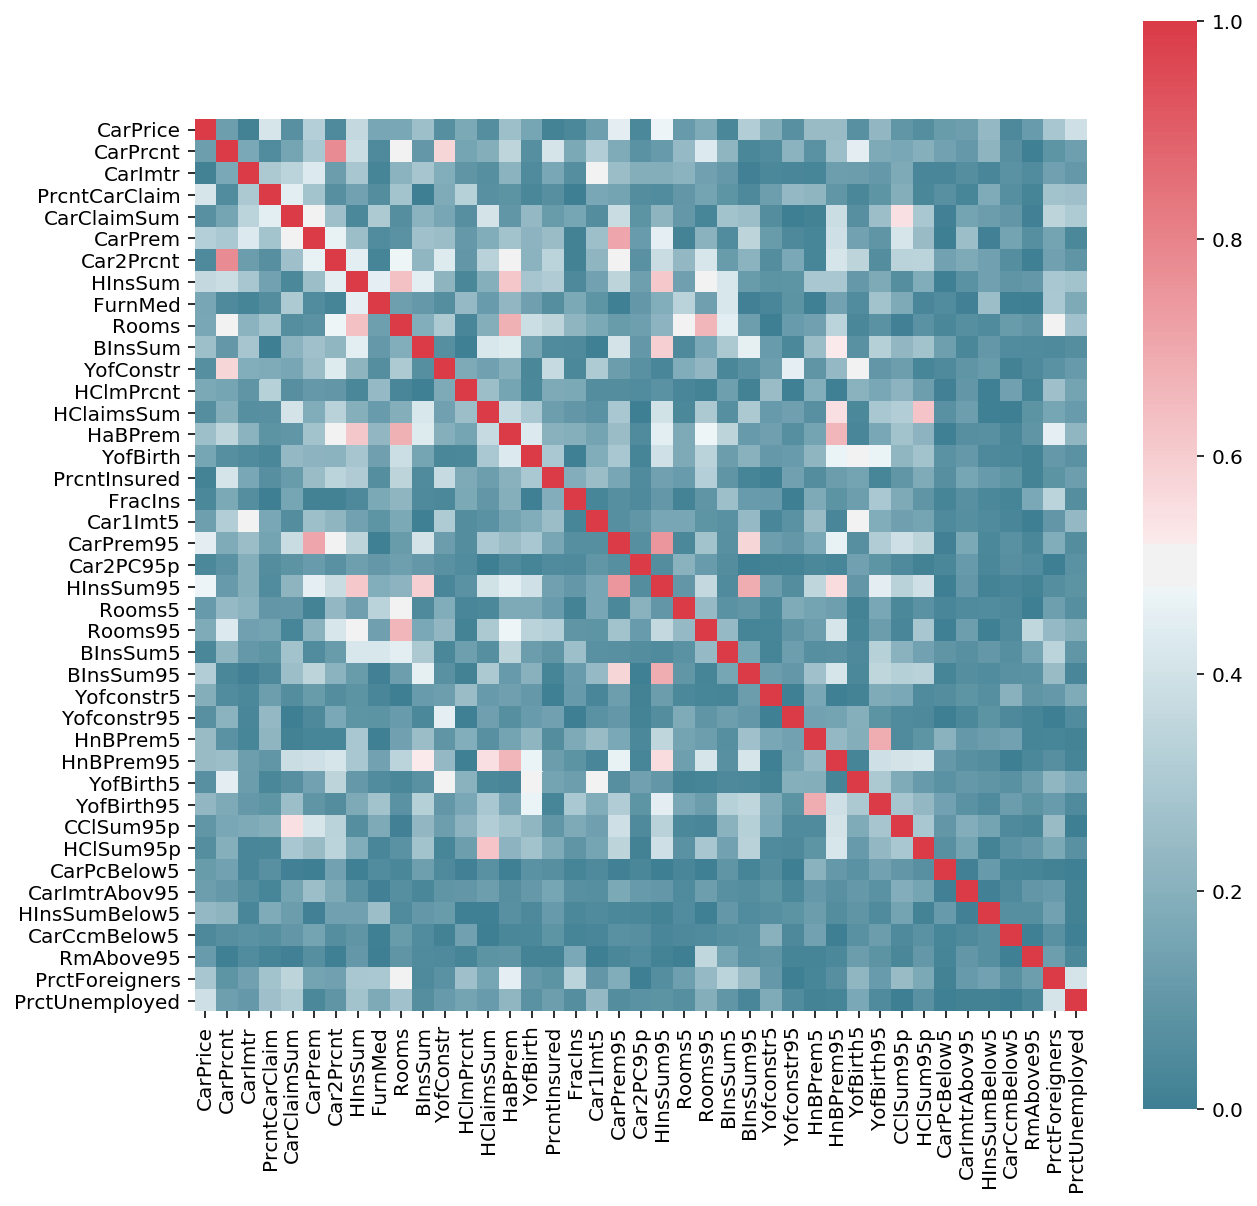

In [405]:
X = dfFeat.drop(['BFS'], axis=1)  ## remove municipality code
corr_matrix = X.corr().abs()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### 7.2 We remove features f14 and feature f34 that are highly correlated with f13 and f33 respectively


In [406]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

dfFeatNC = dfFeat.drop(to_drop, axis=1)


In [407]:
len(dfFeatNC.columns)

42

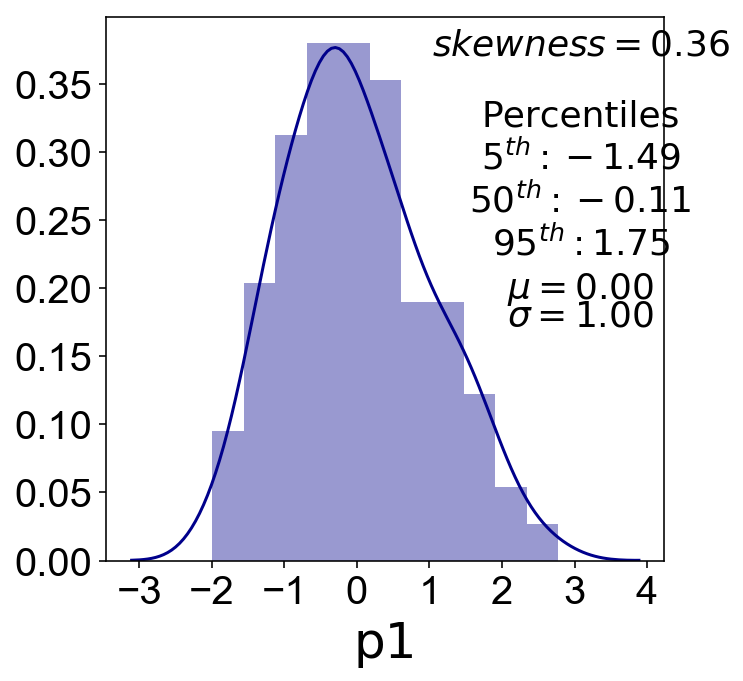

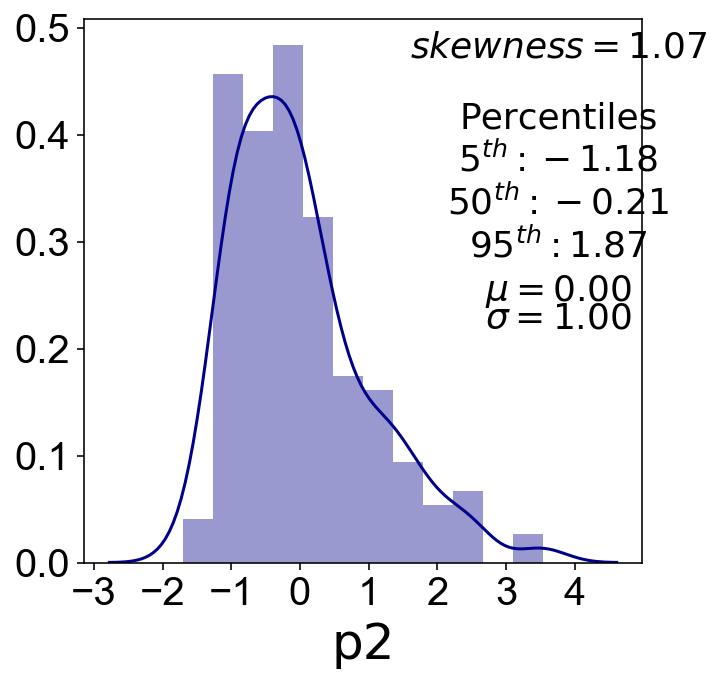

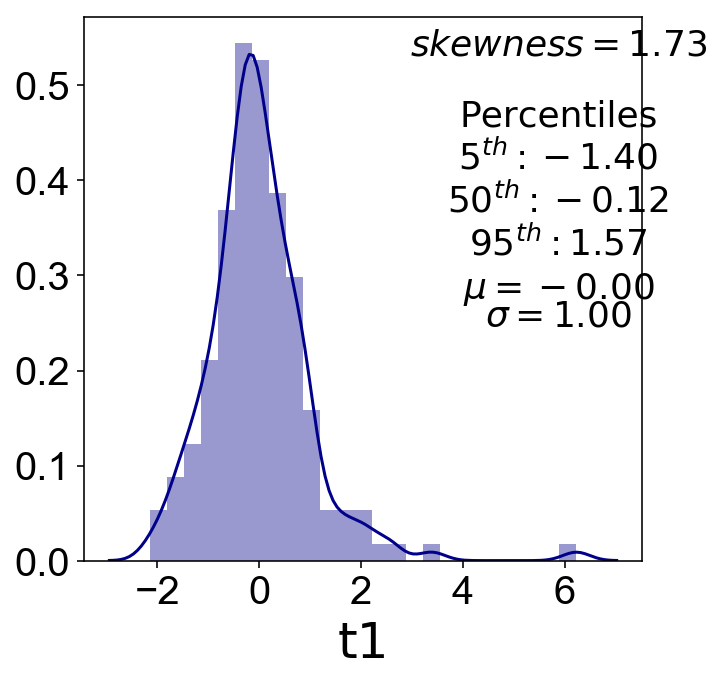

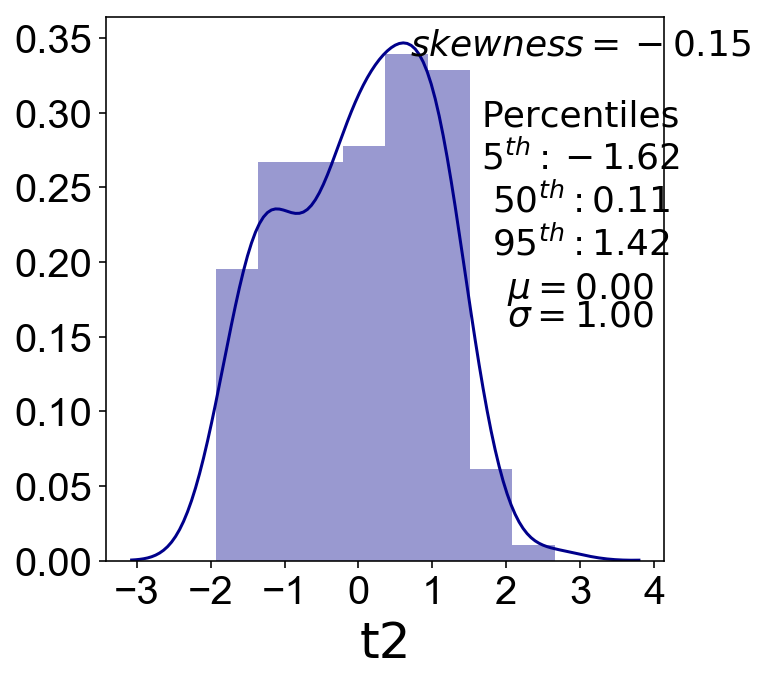

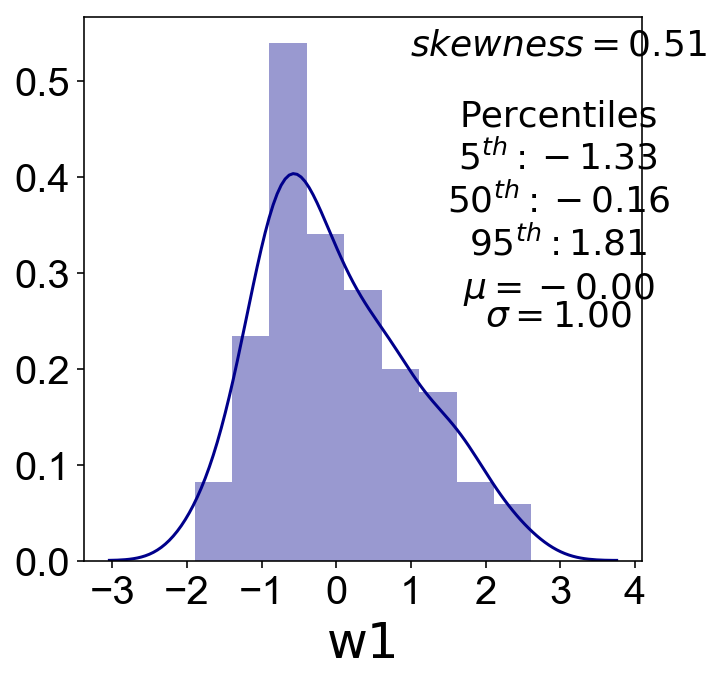

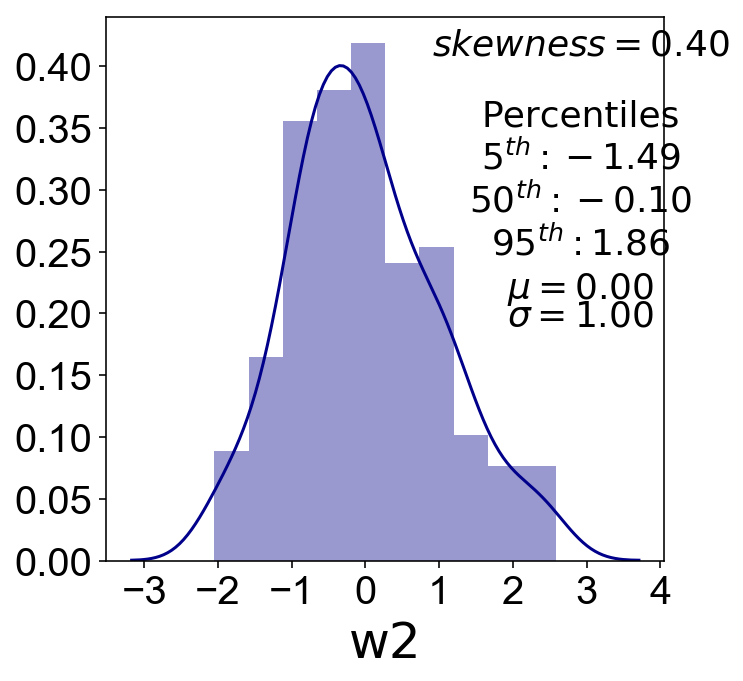

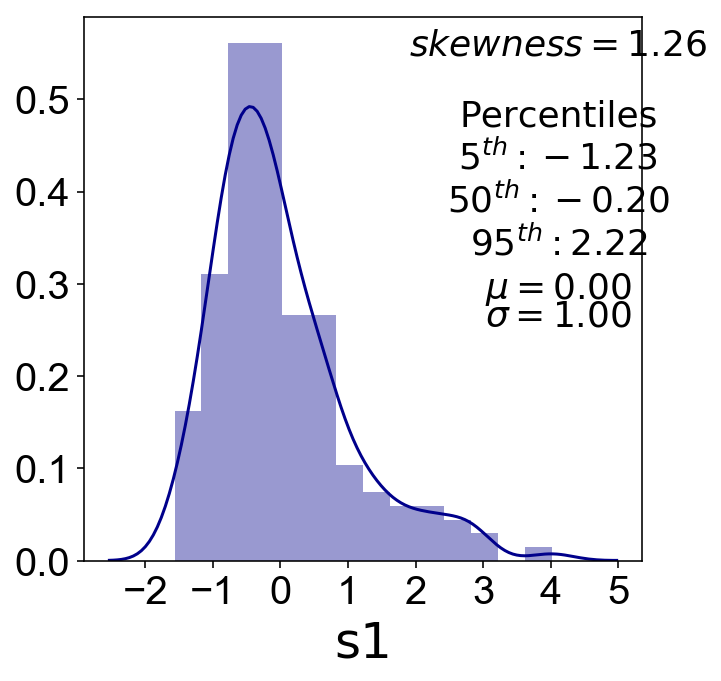

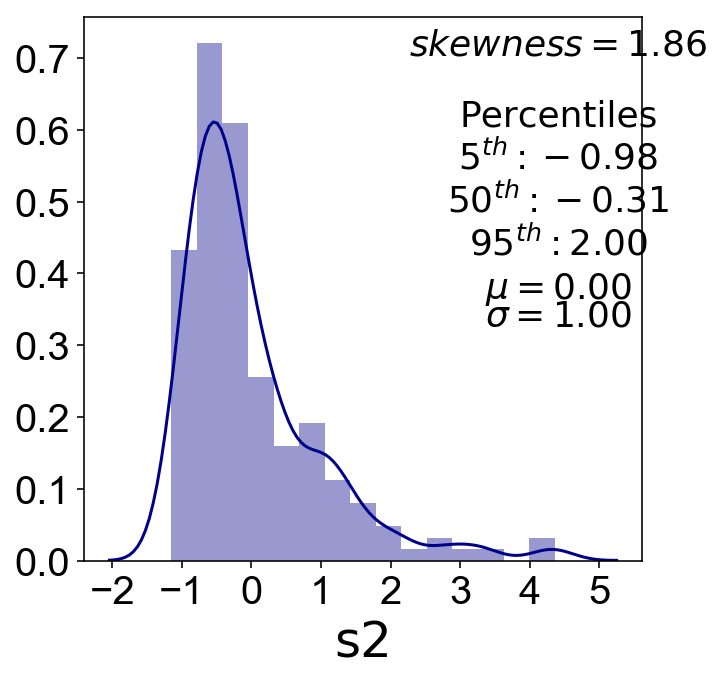

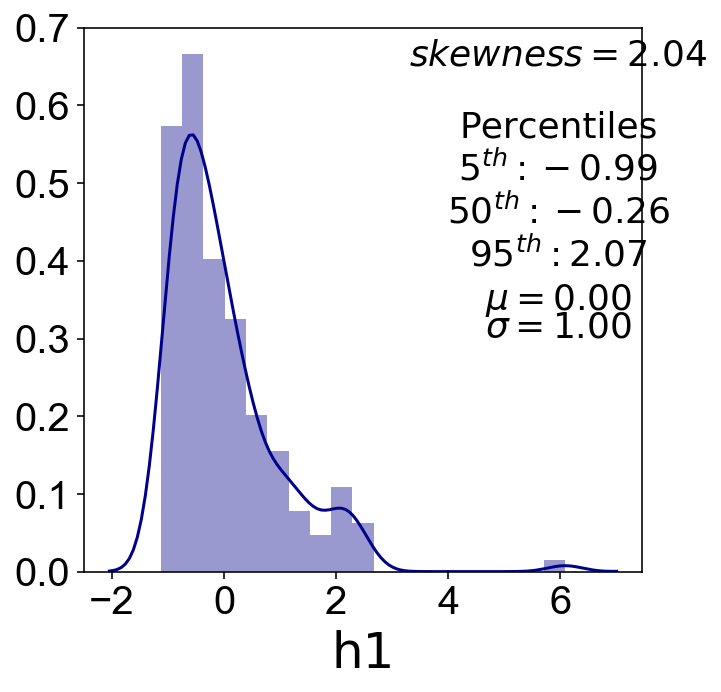

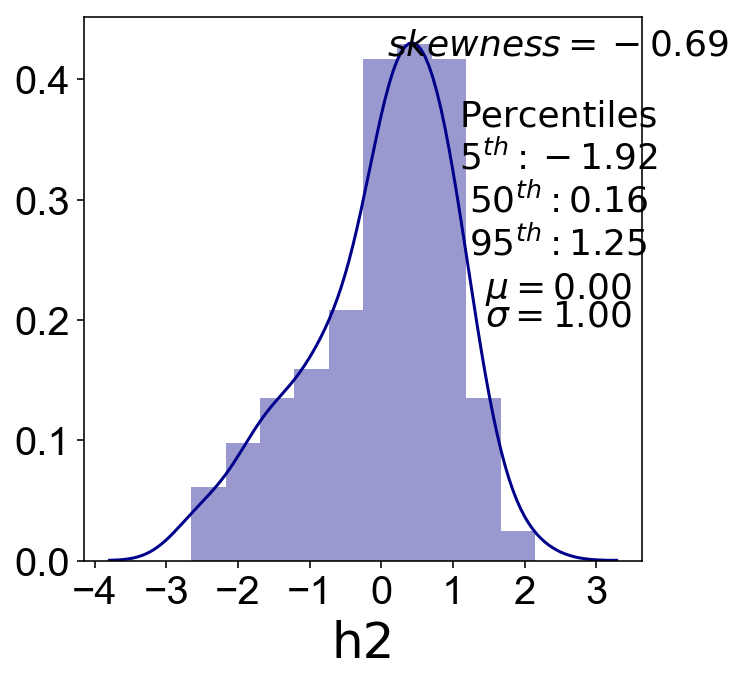

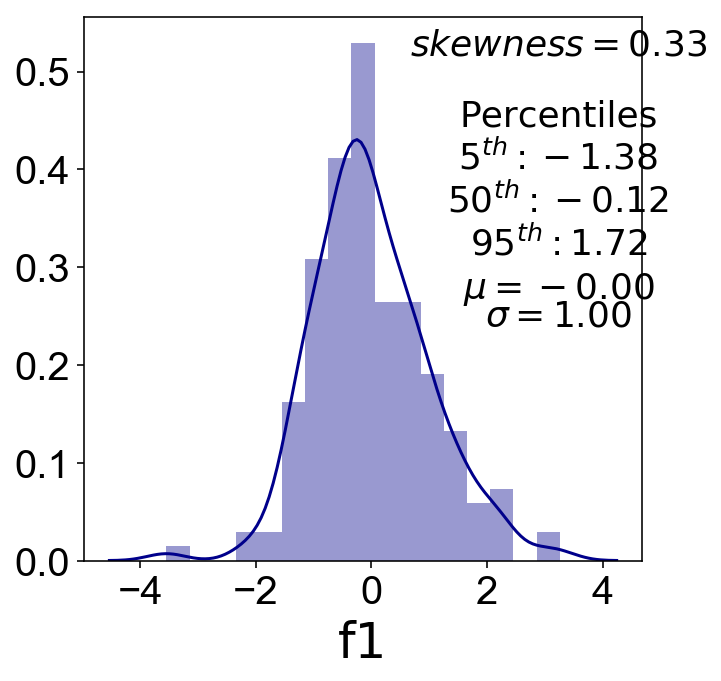

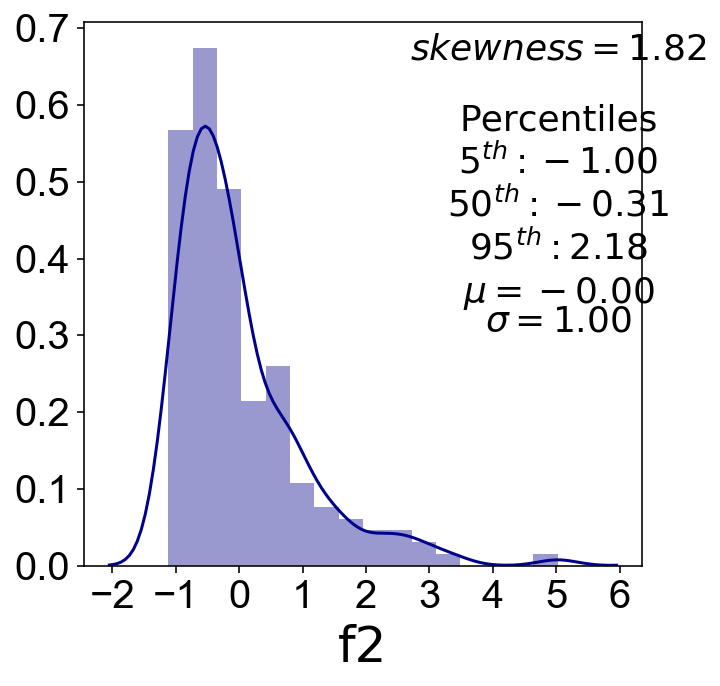

In [408]:
from sklearn import preprocessing
Y = []
scaler = preprocessing.StandardScaler()

for j,i in enumerate(VarDescription):
    f, ax = plt.subplots(figsize=(5, 5))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(20)
    d = sd[i].values
    d=d.reshape((-1,1))
    scaler0 = preprocessing.StandardScaler().fit(d)
    scaler = scaler0.fit(d)
    
    d = scaler.transform(d)
    
    
    
    sns.distplot(d, color='darkblue', ax=ax);
    ax.set_xlabel(VarDescription[j],size = 25)
    
    
    s = skew( d,nan_policy='omit')
    q = np.percentile(d, [5,50,95])
    m = np.mean(d)
    std = np.std(d)
    Y.append(d)
    text(0.85, 0.95,r'$skewness = %.2f$'%s, ha='center', va='center',
        transform=ax.transAxes, fontSize = 18)
    text(0.85, 0.7,'Percentiles'+'\n'+r'$5^{th}: %.2f$'%q[0]+'\n'+r'$50^{th}: %.2f$'%q[1]+'\n'+r'$95^{th}: %.2f$'%q[2], 
         ha='center', va='center',
         transform=ax.transAxes, fontSize = 18)
    text(0.85, 0.5,r'$\mu = %.2f$'%m, ha='center', va='center',
         transform=ax.transAxes, fontSize = 18)
    text(0.85, 0.45,r'$\sigma = %.2f$'%std, ha='center', va='center',
         transform=ax.transAxes, fontSize = 18)

In [409]:
dfFeatNC.head()

,CarPrice,CarPrcnt,CarImtr,PrcntCarClaim,CarClaimSum,CarPrem,Car2Prcnt,HInsSum,FurnMed,Rooms,...,CClSum95p,HClSum95p,CarPcBelow5,CarImtrAbov95,HInsSumBelow5,CarCcmBelow5,RmAbove95,PrctForeigners,PrctUnemployed,BFS
0,34000,0.339635,2010.0,1.386667,1531.600,1135.4,1.890614,69000,0.930909,3.805846,...,12114.8200,6627.6325,6.385965,9.684211,9.660356,5.894737,7.747148,6.639658,0.067522,4001
1,33000,0.360093,2010.0,1.157718,1683.225,1145.0,1.505210,78000,1.026190,3.722591,...,10650.1350,8971.6800,6.375839,12.080537,5.458824,5.033557,11.129568,10.961019,0.077190,131
2,33000,0.421804,2010.0,1.479256,1764.900,1161.7,2.283105,88000,1.327845,4.076511,...,9340.1450,7128.4150,5.865522,5.007153,7.051282,5.293276,6.237817,8.618721,0.399543,2761
3,32000,0.432518,2011.0,1.152392,1777.400,1198.6,2.536232,78000,1.056792,3.924907,...,11942.0075,8145.6750,5.561735,5.784205,5.782710,5.895439,7.929104,10.099638,0.407609,2
4,30000,0.456911,2010.0,1.177606,1968.450,1114.1,3.577236,73000,0.477752,3.542373,...,11835.6800,11548.2500,7.335907,6.177606,9.090909,5.405405,7.627119,25.040650,0.000000,5401


## 8. Separete the City into Different Class

In [410]:
swissData = swissData.sort_values(by = ['BFS'])

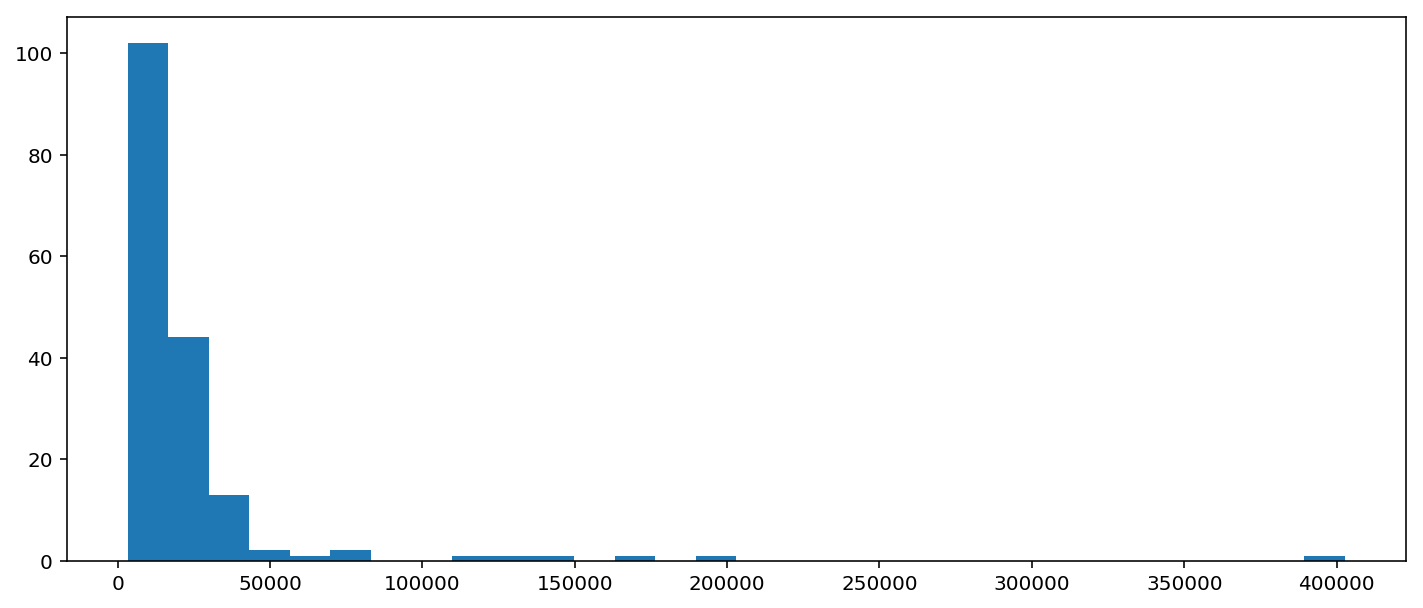

In [411]:
# SEPARATE CITIES INTO DIFFERENT POPULATION CLASSES
pop=swissData['pop1']
categories=np.zeros_like(pop)
categories[pop>25000]=1
categories[pop>100000]=2
cat=[]
for i in categories:
    if i==0:
        cat.append('s')  #small cities
    if i==1:
        cat.append('m')  # medium cities
    if i==2:
        cat.append('l')  # large cities

plt.figure(figsize=(12,5))
plt.hist(pop,30);

### 8.1 Separate the cities in training and validation set based on the population

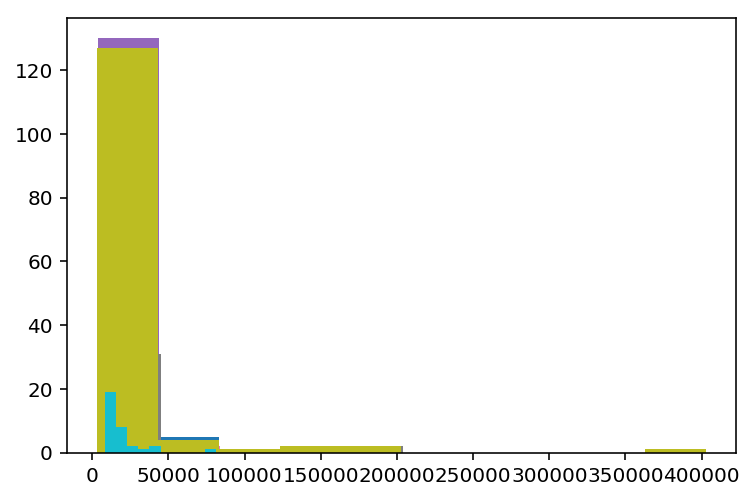

In [412]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(5,shuffle=True) 
for train,test in skf.split(X,cat):
    plt.hist(pop[train])
    plt.hist(pop[test])

## 9. The Model

In [413]:
def setFont(ax, font, size):
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(size)
    return ax

In [414]:
from sklearn import preprocessing
#from sklearn.preprocessing import scale
from sklearn.linear_model import LassoLarsIC
from itertools import combinations

scale = preprocessing.StandardScaler().fit_transform

In [415]:
sd['BFS'] = swissData['BFS']
sd = sd.sort_values(by=['BFS']) ## sort by BFS

In [416]:
## GWR Coord
coord=pd.read_csv('../data/bfs_name_coordinates.csv',delimiter=',', encoding="iso-8859-1")
tmp = dfFeatNC.drop(['BFS'], axis=1)
tmp = pd.merge(dfFeatNC, coord, on = 'BFS')
u = tmp['Xcoord']
v = tmp['Ycoord']
g_coords = list(zip(u,v))

In [417]:
def selectFeaturesPvalue(x,y,X, interaction):
    Xnorm = scale(x)
    y = np.array(y).reshape(-1,1)
    Ynorm = scale(y)
    est  = sm.OLS(Ynorm, sm.add_constant(Xnorm)).fit() # get the pvalues of all the variables but the intercept  
    pval = pd.DataFrame(est.pvalues[1:], columns = ['pvalue'])
    pval['col'] = pval.index 
    pval = pval.sort_values(by=['pvalue']).reset_index(drop=True)
    p_tmp = pval[pval['pvalue'] < 0.05]
    if interaction:
        if len(p_tmp) < 2:
            p_tmp = pval[pval.index < 2]
        elif len(p_tmp) > 15:
            p_tmp = pval[pval.index < 15]
    else:
        if len(p_tmp) < 1:
            p_tmp = pval[pval.index == 0]
    varnames = list(X.columns[[p_tmp['col']]])
    return varnames

def lassoFunc(x, y, Xm, inter):
    V1 = []
    x = scale(x)
    g_y = np.array(y).reshape(-1,1) 
    g_y = scale(g_y)
    model_bic = LassoLarsIC(criterion='aic',normalize=False)
    model_bic.fit(x, ravel(g_y))
    idx=np.squeeze(np.nonzero(model_bic.coef_),axis=1)
    col = X.columns
    if idx.size==0:
        varnames = selectFeaturesPvalue(x, y, X, inter)
    else:
        varnames = list(col[idx])
    return varnames

def permuteCOl(X):
    X_ = X.copy()
    X_ = scale(X_)
    X_ = pd.DataFrame(X_)
    X_.columns = X.columns
    for pair in combinations(X_.columns, 2):
        new_col = '*'.join(pair)
        X_[new_col] = X_[pair[0]] * X_[pair[1]]
    return X_

def interactingVariables(x,y,X, inter):
    g_y = np.array(y).reshape(-1,1) 
    g_y = scale(g_y)
    varnames = selectFeaturesPvalue(x, y, X, inter)  ### select features based on p-value 
    X = X.filter(list(varnames), axis=1) 
    s = X.shape
    if s[1] > 1:  ## if > 1 do interactions
        X_ = permuteCOl(X)
    else:
        X_ = X.copy()
    x_int = scale(X_)

    x_int = X_.values
    x_int = scale(x_int)
    est   = sm.OLS(g_y, x_int).fit()
    pval  = est.pvalues[1:]
    idx = np.where(pval < 0.05)
    idx = list(idx[0])
    X_sel = X_.ix[:,idx] 
    df1 = X.copy()
    df2 = X_sel.copy()
    df22 =  df2.loc[:, ~df2.columns.isin(df1.columns)]
    X_sel = df1.join(df22)
    return X_sel

def selectInteraction(g_y, X_sel):
    x_int = X_sel.values
    est = sm.OLS(g_y, x_int).fit()
    bicnew = est.bic
    pval = est.pvalues[1:]
    model_bic = LassoLarsIC(criterion='bic',normalize=False)
    y_=ravel(g_y)
    model_bic.fit(x_int, y_)
    idx = np.squeeze(np.nonzero(model_bic.coef_),axis=1)
    columns = X_sel.columns
    varnames_sel = X_sel.columns[[idx]]
    if idx.size == 1:
        X = X_sel.filter([varnames_sel], axis = 1)
    else:
        X = X_sel.filter(list(varnames_sel), axis = 1)
    return [X,varnames_sel]

In [418]:
coord = pd.read_csv('../data/bfs_name_coordinates.csv',delimiter=',', encoding="iso-8859-1")
coord = coord.sort_values(by = ['BFS'])
coord.head()

,BFS,CityLaMobiliere,Ycoord,Xcoord
3,2,Affoltern am Albis,236.775344,676.618596
17,52,Bassersdorf,256.126949,688.340371
30,53,Bülach,264.944544,682.936823
62,62,Kloten,257.205346,686.061892
104,66,Opfikon,254.970962,685.339978


In [420]:
sd1 = sd.copy()
sd1 = sd1.drop(['BFS'], axis=1)
cases = [0,1,2]
r2 = []
R2 = []
V = []
for case in cases[0:1]:
    pvalue = False
    lasso = False
    interactions = False
    v  = []
    if case == 0:
        pvalue = True
    elif case == 1:
        lasso = True
    elif case == 2:
        interactions = True
    else:
        print('Not a possible case')
    for i in sd1.columns:
        y = sd1[i]
        g_y = np.array(y).reshape(-1,1) 
        g_y = scale(g_y)
        X = dfFeatNC.drop(['BFS'], axis=1)  
        x = X.values
        if pvalue:
            inter = False
            varnames = selectFeaturesPvalue(x, y, X, inter)
            v.append(varnames)
            X = X.filter(list(varnames), axis=1)
        elif lasso:
            inter = False
            varnames = lassoFunc(x, y, X, inter)
            v.append(varnames)
            X = X.filter(list(varnames), axis=1)
        elif interactions:
            inter = True
            X_sel = interactingVariables(x,y,X,inter)
            x_int = X_sel.values
            est = sm.OLS(g_y, scale(x_int)).fit()
            bicnew = est.bic
            pval = est.pvalues[1:]
            model_bic = LassoLarsIC(criterion='bic',normalize=False)
            y_=ravel(g_y)
            model_bic.fit(x_int, y_)
            idx = np.squeeze(np.nonzero(model_bic.coef_),axis=1)
            columns = X_sel.columns
            varnames_sel = X_sel.columns[[idx]]
            if idx.size == 1:
                X = X_sel.filter([varnames_sel], axis = 1)
            else:
                X = X_sel.filter(list(varnames_sel), axis = 1)
            v.append(list(varnames_sel))
        g_x = X.values
        g_x = scale(g_x)
        gwr_bw = Sel_BW(g_coords, g_y, g_x, kernel='gaussian',fixed=True).search(criterion='AICc')
        gwr_results = GWR(g_coords, g_y, g_x, gwr_bw).fit()
            ## Simple Linear regression model\
        reg = sm.OLS(g_y, g_x).fit()
        R2.append(gwr_results.R2)
            ## try lasso
        r2.append(reg.rsquared);
    V.append(v)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [421]:
styles=['bs--', 'ro-.', 'y^-']
gwr = np.reshape(R2, (3, 12))
gwr = pd.DataFrame(gwr.T)
gwr.columns = ['Simple', 'Lasso', 'Interactions']
gwr.index = sd1.columns

r2 = np.reshape(r2, (3, 12))
r2 = pd.DataFrame(r2.T)
r2.columns = ['Simple', 'Lasso', 'Interactions']
r2.index = sd1.columns

f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
gwr.plot(kind='bar', ax=ax)
ax = r2.plot(ax=ax, lw=2, style=styles)
for i, l in enumerate(ax.lines):
    plt.setp(l, color='black', lw = 2, markersize = 8)
ax.set_xticks(np.arange(len(sd1.columns)));
ax.legend(fontsize=18, bbox_to_anchor=(1.01,1))
ax.set_xlim([-0.5, 11.5]);

ValueError: cannot reshape array of size 12 into shape (3,12)

### 10.1 Cross Validation

In [389]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
generator = StratifiedKFold(5,shuffle=True) # 5 fold cv

In [390]:
coord = pd.read_csv('../data/bfs_name_coordinates.csv',delimiter=',', encoding="iso-8859-1")
coord = coord.sort_values(by = ['BFS'])
coord.head()

,BFS,CityLaMobiliere,Ycoord,Xcoord
3,2,Affoltern am Albis,236.775344,676.618596
17,52,Bassersdorf,256.126949,688.340371
30,53,Bülach,264.944544,682.936823
62,62,Kloten,257.205346,686.061892
104,66,Opfikon,254.970962,685.339978


In [391]:
coord = coord.reset_index(drop=True)

### P-Value

In [392]:
r2ValMean = []
r2ValStd  = []
r2TrMean = []
r2TrStd  = []
sd1 = sd.copy()
sd1 = sd1.drop(['BFS'], axis=1)
sd1 = sd1.reset_index(drop=True)
for j,i in enumerate(sd1.columns):
    y    = sd1[i]
    g_y  = np.array(y).reshape(-1,1) 
    g_y  = scale(g_y)
    
    X    = dfFeatNC.drop(['BFS'], axis=1)  
    col  = V[1][j]  ## Selected Features
    X    = X.filter(col, axis=1) ## Features
    X    = X.reset_index(drop=True)
    Rval = []
    Rtr = []
    for train_index, test_index in generator.split(X, categories):
        
        c_train = coord[coord.index.isin(train_index)]
        u = c_train['Xcoord']
        v = c_train['Ycoord']
        c_train = list(zip(u,v))
        
        c_test  = coord[coord.index.isin(test_index)]
        u = c_test['Xcoord']
        v = c_test['Ycoord']
        c_test = list(zip(u,v))

        ytrain = g_y[train_index]
        ytest  = g_y[test_index]
        
        xtrain = scale(X[X.index.isin(train_index)])
        xtest  = scale(X[X.index.isin(test_index)])
        
        gwr_bw      = Sel_BW(c_train, ytrain, xtrain, kernel='gaussian',fixed=True).search(criterion='AICc')
        gwr_results = GWR(c_train, ytrain, xtrain, gwr_bw).fit()
        yest        = np.sum(sm.add_constant(xtrain) * gwr_results.params, axis=1).reshape((-1, 1)) 
        Rtr.append(r2_score(ytrain, yest)) ## training
        
        #gwr_results = GWR(c_test, yest, xtest, gwr_bw).fit()
        Res    = GWR.predict(gwr_results.model, c_test, ytest) # predict in the testing locations 
        ypred  = np.sum(sm.add_constant(xtest) * Res.params, axis=1).reshape((-1, 1))
        Rval.append(r2_score(ytest,ypred))  ## validation
        
    r2ValMean.append(np.mean(Rval))
    r2ValStd.append(np.std(Rval))
    
    r2TrMean.append(np.mean(Rtr))
    r2TrStd.append(np.std(Rtr))

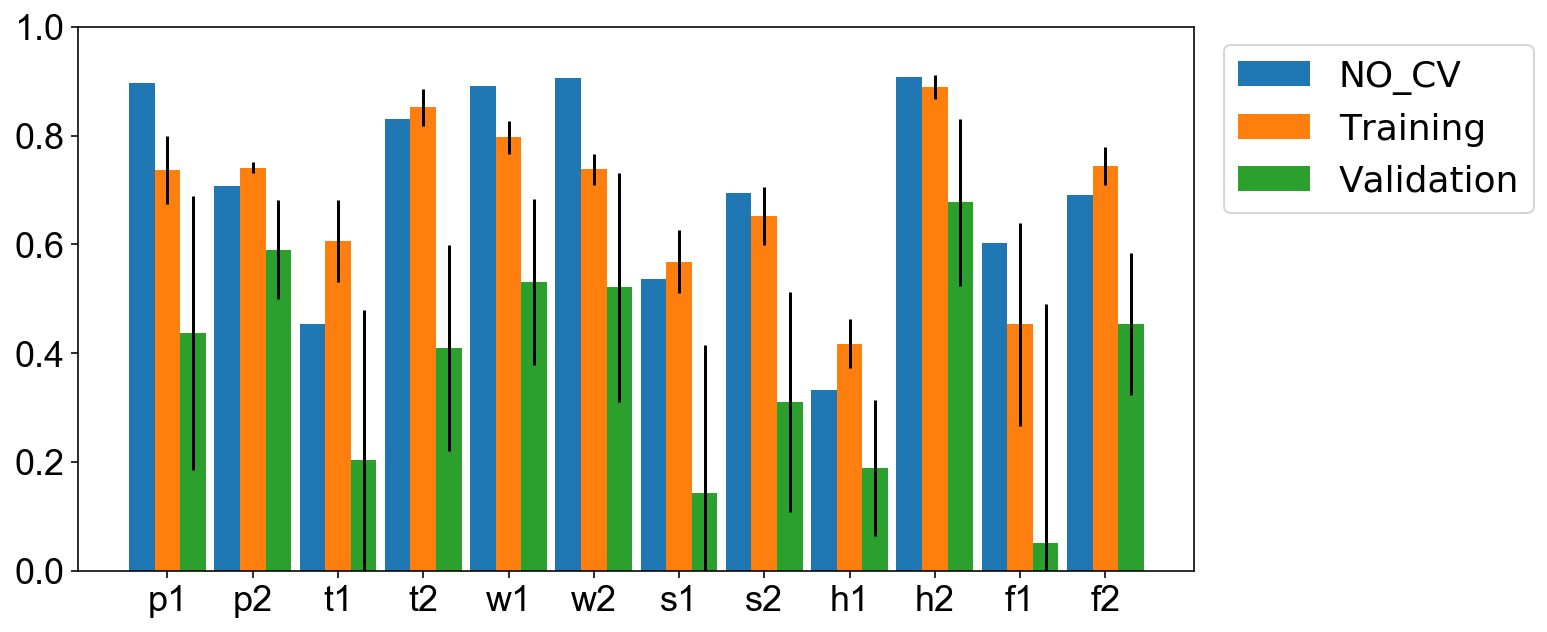

In [393]:
df = pd.DataFrame()
df['R2'] = gwr['Simple']
df['Training'] = r2TrMean
df['Validation'] = r2ValMean
df['TrainingError'] = r2TrStd
df['ValidationError'] = r2ValStd

width = 0.3 

r1 = np.arange(len(df))
r2 = [x + width for x in r1]
r0 = [x - width for x in r1]
 
fig,ax = plt.subplots(figsize=(10,5))
ax = setFont(ax, 'Arial', 18)
p0 = ax.bar(r0, df['R2'], width, align='center', ecolor='k')
p1 = ax.bar(r1, df['Training'], width, align='center', yerr=df['TrainingError'], ecolor='k')
p2 = ax.bar(r2, df['Validation'], width, align='center',yerr=df['ValidationError'], ecolor='k')

plt.xticks(np.arange(len(nameVariables)),nameVariables)
ax.set_ylim([0,1]);
ax.legend(['NO_CV', 'Training','Validation'],fontsize=18, bbox_to_anchor=(1.01,1))

### Interactions

In [396]:
r2ValMean = []
r2ValStd  = []
r2TrMean = []
r2TrStd  = []
sd1 = sd.copy()
sd1 = sd1.drop(['BFS'], axis=1)
sd1 = sd1.reset_index(drop=True)
V[2][10] = 'f27_'
for j,i in enumerate(sd1.columns):
    y    = sd1[i]
    g_y  = np.array(y).reshape(-1,1) 
    g_y  = scale(g_y)
    X    = dfFeatNC.drop(['BFS'], axis=1)  
    x    = X.values
    col  = V[2][j]  ## Selected Features
    X    = dfFeatNC.drop(['BFS'], axis=1)  
    X    = permuteCOl(X)
    
    X    = X.filter(col, axis=1) ## Features
    if j == 10:
        X = dfFeatNC.drop(['BFS'], axis=1)  
        X = X.filter(['f27_'], axis=1)
    Rval = []
    Rtr = []
    for train_index, test_index in generator.split(X,categories):
        c_train = coord[coord.index.isin(train_index)]
        u = c_train['Xcoord']
        v = c_train['Ycoord']
        c_train = list(zip(u,v))
        
        c_test  = coord[coord.index.isin(test_index)]
        u = c_test['Xcoord']
        v = c_test['Ycoord']
        c_test = list(zip(u,v))

        ytrain = scale(g_y[train_index])
        ytest  = scale(g_y[test_index])
        
        xtrain = scale(X[X.index.isin(train_index)])
        xtest  = scale(X[X.index.isin(test_index)])
        
        gwr_bw = Sel_BW(c_train, ytrain, xtrain, kernel='gaussian',fixed=True).search(criterion='AICc')
        gwr_results = GWR(c_train, ytrain, xtrain, gwr_bw).fit()
        yest=np.sum(sm.add_constant(xtrain) * gwr_results.params, axis=1).reshape((-1, 1)) 
        Rtr.append(r2_score(ytrain,yest)) 
        
        
        Res    = GWR.predict(gwr_results.model,c_test,ytest) # predict in the testing locations 
        ypred  = np.sum(sm.add_constant(xtest) * Res.params, axis=1).reshape((-1, 1))
        Rval.append(r2_score(ytest,ypred))
        
    r2ValMean.append(np.mean(Rval))
    r2ValStd.append(np.std(Rval))
    
    r2TrMean.append(np.mean(Rtr))
    r2TrStd.append(np.std(Rtr))

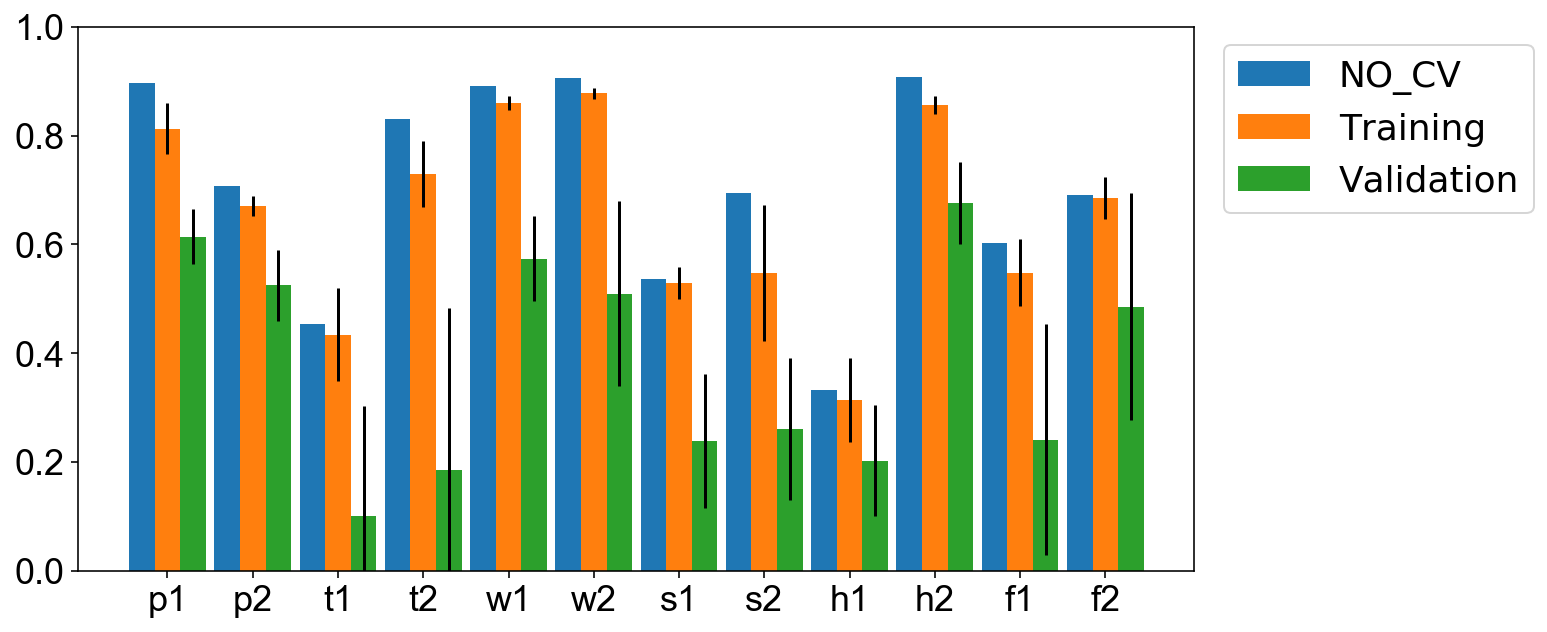

In [397]:
df = pd.DataFrame()
df['R2'] = gwr['Simple']
df['Training'] = r2TrMean
df['Validation'] = r2ValMean
df['TrainingError'] = r2TrStd
df['ValidationError'] = r2ValStd

width = 0.3 
r1 = np.arange(len(df))
r2 = [x + width for x in r1]
r0 = [x - width for x in r1]
 
fig,ax = plt.subplots(figsize=(10,5))
ax = setFont(ax, 'Arial', 18)
p0 = ax.bar(r0, df['R2'], width, align='center', ecolor='k')
p1 = ax.bar(r1, df['Training'], width, align='center', yerr=df['TrainingError'], ecolor='k')
p2 = ax.bar(r2, df['Validation'], width, align='center',yerr=df['ValidationError'], ecolor='k')

plt.xticks(np.arange(len(nameVariables)),nameVariables)
ax.set_ylim([0,1]);
ax.legend(['NO_CV', 'Training','Validation'],fontsize=18, bbox_to_anchor=(1.01,1))